# DeepLense Foundation Representation Learning

## Problem Statement
- Strong gravitational lensing tasks often rely on models trained for a single objective such as classification.
- These approaches may not learn reusable feature representations across different lensing problems.
- Representation learning using autoencoders can help build a shared foundation for multiple downstream tasks.
- The goal of this project is to learn a general encoder that improves performance across classification and future regression tasks.

## Objectives
- Pretrain an encoder using an autoencoder on lensing images.
- Use the pretrained encoder for downstream classification.
- Explore multi-task learning with reconstruction and classification.
- Evaluate whether representation learning improves generalization.
- Prepare the encoder for future regression tasks such as lens parameter estimation.


In [ ]:
# SETUP
!pip install torch torchvision matplotlib tqdm scikit-learn

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import random


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import random
from torch.utils.data import Dataset
import os, numpy as np, torch

class SmallLensDataset(Dataset):
    def __init__(self, data_dir, transform=None, max_per_class=3500):
        self.samples = []
        self.class_names = ["no", "sphere", "vort"]
        self.transform = transform

        for label, cname in enumerate(self.class_names):
            cdir = os.path.join(data_dir, cname)
            files = [f for f in os.listdir(cdir) if f.endswith(".npy")]


            if max_per_class:
                files = random.sample(files, min(max_per_class, len(files)))

            for f in files:
                self.samples.append((os.path.join(cdir, f), label))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        arr = np.load(path, allow_pickle=True)
        arr = np.squeeze(arr)

        mn, mx = arr.min(), arr.max()
        if mx > mn:
            arr = (arr - mn) / (mx - mn)

        img = torch.from_numpy(arr).float().unsqueeze(0)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_path = "/content/drive/MyDrive/archive (3)/dataset - Copy/dataset/train"
val_path   = "/content/drive/MyDrive/archive (3)/dataset - Copy/dataset/val"

for c in os.listdir(train_path):
    p = os.path.join(train_path, c)
    print(c, "->", len(os.listdir(p)))


no -> 10005
sphere -> 10000
vort -> 10001


In [ ]:
sample = np.load(f"{train_path}/no/1.npy")
print("Image shape:", sample.shape)


Image shape: (1, 150, 150)


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
])

train_dataset = SmallLensDataset(train_path, transform=train_transform, max_per_class=3500)

val_dataset = SmallLensDataset(val_path, max_per_class=None)

loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

VAL_SIZE = min(3000, len(val_dataset))
all_idx = list(range(len(val_dataset)))
random.shuffle(all_idx)

val_loader = DataLoader(
    torch.utils.data.Subset(val_dataset, all_idx[:VAL_SIZE]),
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train size: {len(train_dataset)}  Val size: {VAL_SIZE}")

Train size: 10500  Val size: 3000


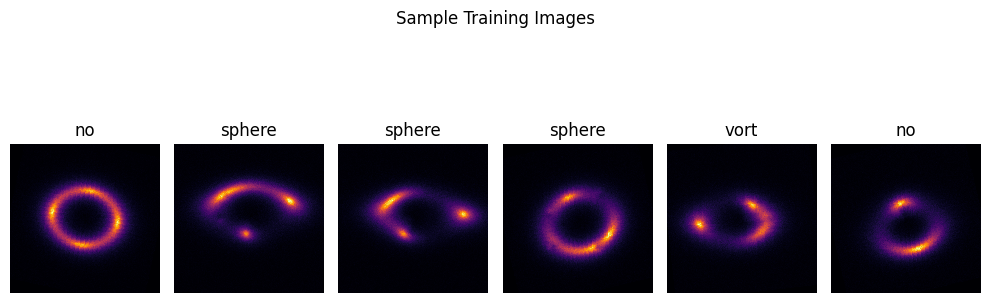

In [ ]:
imgs, labels = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True)))
plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(imgs[i][0], cmap="inferno")
    plt.title(["no","sphere","vort"][labels[i].item()])
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()


## Approach / Methodology
- A convolutional autoencoder is trained to learn latent representations from lensing images.
- The encoder component is extracted and used as a shared feature backbone.
- A classification head is attached to perform lens detection.
- A multi-task learning setup is explored where the model simultaneously performs reconstruction and classification.
- Performance is compared with a baseline model trained without representation pretraining.
- The learned encoder is designed to serve as a reusable foundation for future tasks including regression.

## Experimental Setup

- The experiments are conducted on simulated gravitational lensing images containing three classes: no substructure, spherical substructure, and vortex substructure.
- Images are normalized and augmented using flips and rotations to improve generalization.
- Models are trained using the Adam optimizer with weight decay regularization.
- Classification performance is evaluated using validation accuracy and ROC/AUC metrics.
- Representation quality is assessed by comparing autoencoder-based features, supervised baseline features, and multi-task foundation model features.
- All experiments are implemented using PyTorch with GPU acceleration.

In [ ]:
class LensAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        out = out[:, :, :x.shape[2], :x.shape[3]]
        return out

ae = LensAutoencoder().cuda()
ae_opt = torch.optim.Adam(ae.parameters(), lr=3e-4)
ae_loss_fn = nn.MSELoss()
print("Autoencoder ready ✔")


Autoencoder ready ✔


In [ ]:
ae.train()

for epoch in range(5):
    running = 0.0
    for i, (imgs, _) in enumerate(loader):
        imgs = imgs.cuda().float()
        recon = ae(imgs)
        loss = ae_loss_fn(recon, imgs)

        ae_opt.zero_grad()
        loss.backward()
        ae_opt.step()

        running += loss.item()
        if i % 50 == 0:
            print(f"AE Epoch {epoch} step {i} loss {loss.item():.6f}")

    print(f"AE Epoch {epoch} avg loss {running/len(loader):.6f}")

print("Autoencoder training done ✔")


AE Epoch 0 step 0 loss 0.014362
AE Epoch 0 step 50 loss 0.003515
AE Epoch 0 step 100 loss 0.001230
AE Epoch 0 step 150 loss 0.000727
AE Epoch 0 avg loss 0.004116
AE Epoch 1 step 0 loss 0.000652
AE Epoch 1 step 50 loss 0.000483
AE Epoch 1 step 100 loss 0.000407
AE Epoch 1 step 150 loss 0.000317
AE Epoch 1 avg loss 0.000436
AE Epoch 2 step 0 loss 0.000307
AE Epoch 2 step 50 loss 0.000283
AE Epoch 2 step 100 loss 0.000251
AE Epoch 2 step 150 loss 0.000220
AE Epoch 2 avg loss 0.000264
AE Epoch 3 step 0 loss 0.000226
AE Epoch 3 step 50 loss 0.000223
AE Epoch 3 step 100 loss 0.000210
AE Epoch 3 step 150 loss 0.000226
AE Epoch 3 avg loss 0.000211
AE Epoch 4 step 0 loss 0.000193
AE Epoch 4 step 50 loss 0.000187
AE Epoch 4 step 100 loss 0.000177
AE Epoch 4 step 150 loss 0.000185
AE Epoch 4 avg loss 0.000186
Autoencoder training done ✔


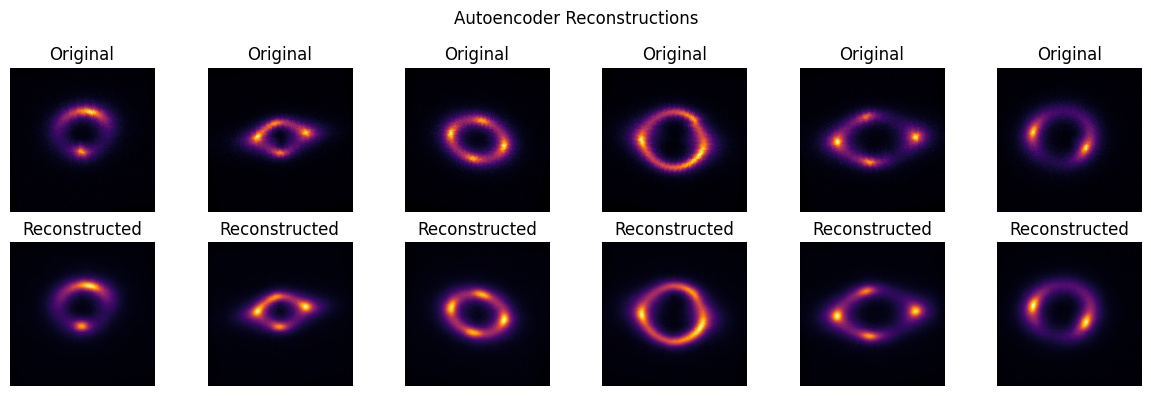

Reconstruction plot saved ✔


In [ ]:
ae.eval()
imgs, _ = next(iter(loader))
imgs = imgs.cuda().float()

with torch.no_grad():
    recon = ae(imgs)

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(imgs[i][0].cpu(), cmap="inferno")
    plt.title("Original")
    plt.axis("off")
    plt.subplot(2, 6, i+7)
    plt.imshow(recon[i][0].cpu(), cmap="inferno")
    plt.title("Reconstructed")
    plt.axis("off")
plt.suptitle("Autoencoder Reconstructions")
plt.tight_layout()
plt.savefig("reconstructions.png")
plt.show()
print("Reconstruction plot saved ✔")


## Autoencoder Results

- The convolutional autoencoder successfully reconstructs the global morphology of gravitational lensing images, achieving low reconstruction loss.
- Visual inspection shows that major structural features such as arcs and brightness distributions are preserved.
- Despite good reconstruction quality, reconstruction alone does not guarantee discriminative representations for downstream classification tasks.
- This motivates evaluating the encoder features through a classification experiment.

In [ ]:
class EncoderClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),next

            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)

clf = EncoderClassifier(ae.encoder).cuda()

for p in clf.encoder.parameters():
    p.requires_grad = True

opt_clf = torch.optim.Adam(clf.parameters(), lr=1e-4, weight_decay=1e-4)
clf_loss_fn = nn.CrossEntropyLoss()
print("Encoder classifier ready ✔")


Encoder classifier ready ✔


In [ ]:
clf.train()

for epoch in range(10):
    running_loss, running_acc = 0.0, 0.0

    for i, (imgs, labels) in enumerate(loader):
        imgs   = imgs.cuda().float()
        labels = labels.cuda()

        out  = clf(imgs)
        loss = clf_loss_fn(out, labels)

        opt_clf.zero_grad()
        loss.backward()
        opt_clf.step()

        running_acc  += (out.argmax(1) == labels).float().mean().item()
        running_loss += loss.item()

        if i % 50 == 0:
            print(f"CLF Epoch {epoch} step {i} loss {loss.item():.4f}")

    val_acc = evaluate(clf, val_loader)
    print(f"Epoch {epoch} - train acc {running_acc/len(loader):.3f}  val acc {val_acc:.3f} ✅")


CLF Epoch 0 step 0 loss 1.1069
CLF Epoch 0 step 50 loss 1.0982
CLF Epoch 0 step 100 loss 1.1008
CLF Epoch 0 step 150 loss 1.1002
Epoch 0 - train acc 0.332  val acc 0.334 ✅
CLF Epoch 1 step 0 loss 1.0961
CLF Epoch 1 step 50 loss 1.0982
CLF Epoch 1 step 100 loss 1.0920
CLF Epoch 1 step 150 loss 1.0965
Epoch 1 - train acc 0.337  val acc 0.345 ✅
CLF Epoch 2 step 0 loss 1.0966
CLF Epoch 2 step 50 loss 1.0992
CLF Epoch 2 step 100 loss 1.1018
CLF Epoch 2 step 150 loss 1.0994
Epoch 2 - train acc 0.332  val acc 0.343 ✅
CLF Epoch 3 step 0 loss 1.0967
CLF Epoch 3 step 50 loss 1.1002
CLF Epoch 3 step 100 loss 1.0991
CLF Epoch 3 step 150 loss 1.1001
Epoch 3 - train acc 0.330  val acc 0.343 ✅
CLF Epoch 4 step 0 loss 1.1019
CLF Epoch 4 step 50 loss 1.0963
CLF Epoch 4 step 100 loss 1.0976
CLF Epoch 4 step 150 loss 1.0994
Epoch 4 - train acc 0.329  val acc 0.325 ✅
CLF Epoch 5 step 0 loss 1.0972
CLF Epoch 5 step 50 loss 1.1002
CLF Epoch 5 step 100 loss 1.1000
CLF Epoch 5 step 150 loss 1.0965
Epoch 5 - t

## AE Encoder Classification Results

- A classification head is trained on top of the frozen autoencoder encoder to evaluate representation quality.
- The resulting accuracy remains close to random performance, indicating that reconstruction-focused features lack strong class separability.
- This highlights the limitation of purely unsupervised reconstruction objectives for discriminative tasks.
- The observed gap motivates exploring supervised and multi-task approaches for improved representation learning.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights


class FoundationModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x, return_features=False):
        feats = self.encoder(x)
        feats = torch.flatten(feats, 1)

        if return_features:
            return feats

        return self.head(feats)


base = resnet18(weights=ResNet18_Weights.DEFAULT)

old_conv = base.conv1
new_conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)

base.conv1 = new_conv

encoder = nn.Sequential(*list(base.children())[:-1])


head = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 3)
)


model = FoundationModel(encoder, head).cuda()

print("Model ready")
print("Total params:", sum(p.numel() for p in model.parameters()))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


Model ready
Total params: 11302339


In [ ]:

for p in model.encoder.parameters():
    p.requires_grad = False

for p in model.encoder[5].parameters():  # layer2
    p.requires_grad = True
for p in model.encoder[6].parameters():  # layer3
    p.requires_grad = True
for p in model.encoder[7].parameters():  # layer4
    p.requires_grad = True

for p in model.head.parameters():
    p.requires_grad = True

opt = torch.optim.Adam([
    {"params": model.encoder[5].parameters(), "lr": 1e-4},
    {"params": model.encoder[6].parameters(), "lr": 7e-5},
    {"params": model.encoder[7].parameters(), "lr": 5e-5},
    {"params": model.head.parameters(),        "lr": 3e-4},
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
loss_fn = nn.CrossEntropyLoss()

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable params: 11151107


In [ ]:
def evaluate(mdl, loader):
    was_training = mdl.training
    mdl.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.cuda(non_blocking=True)
            labels = labels.cuda()

            logits, _ = mdl(imgs)
            pred = logits.argmax(1)

            correct += (pred == labels).sum().item()
            total += labels.size(0)

    if was_training:
        mdl.train()

    return correct / total

In [ ]:
model = model.cuda()
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (imgs, labels) in enumerate(loader):
        imgs = imgs.cuda(non_blocking=True)
        labels = labels.cuda()

        out = model(imgs)
        loss = loss_fn(out, labels)

        opt.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(
            [p for p in model.parameters() if p.requires_grad], 1.0
        )

        opt.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

        if i % 50 == 0:
            print(f"Epoch {epoch} step {i}/{len(loader)} loss {loss.item():.4f}")

    scheduler.step()

    train_acc = correct / total
    val_acc = evaluate(model, val_loader)
    avg_loss = running_loss / len(loader)

    print(f"Epoch {epoch} - loss {avg_loss:.4f}  train acc {train_acc:.3f}  val acc {val_acc:.3f} ✅")

torch.save(model.state_dict(), "phase1_model.pt")
print("Phase 1 saved ✔")

Epoch 0 step 0/165 loss 1.1214
Epoch 0 step 50/165 loss 1.1116
Epoch 0 step 100/165 loss 1.0670
Epoch 0 step 150/165 loss 1.0807
Epoch 0 - loss 1.1111  train acc 0.346  val acc 0.378 ✅
Epoch 1 step 0/165 loss 1.0614
Epoch 1 step 50/165 loss 1.0547
Epoch 1 step 100/165 loss 1.0696
Epoch 1 step 150/165 loss 1.0769
Epoch 1 - loss 1.0733  train acc 0.396  val acc 0.428 ✅
Epoch 2 step 0/165 loss 1.0620
Epoch 2 step 50/165 loss 1.0523
Epoch 2 step 100/165 loss 0.9831
Epoch 2 step 150/165 loss 1.0646
Epoch 2 - loss 1.0391  train acc 0.436  val acc 0.456 ✅
Epoch 3 step 0/165 loss 1.0276
Epoch 3 step 50/165 loss 1.0112
Epoch 3 step 100/165 loss 0.9936
Epoch 3 step 150/165 loss 0.9058
Epoch 3 - loss 1.0069  train acc 0.472  val acc 0.487 ✅
Epoch 4 step 0/165 loss 0.9463
Epoch 4 step 50/165 loss 0.9993
Epoch 4 step 100/165 loss 1.0833
Epoch 4 step 150/165 loss 0.9754
Epoch 4 - loss 0.9824  train acc 0.496  val acc 0.490 ✅
Epoch 5 step 0/165 loss 0.8910
Epoch 5 step 50/165 loss 0.9929
Epoch 5 step

Macro AUC: 0.8113


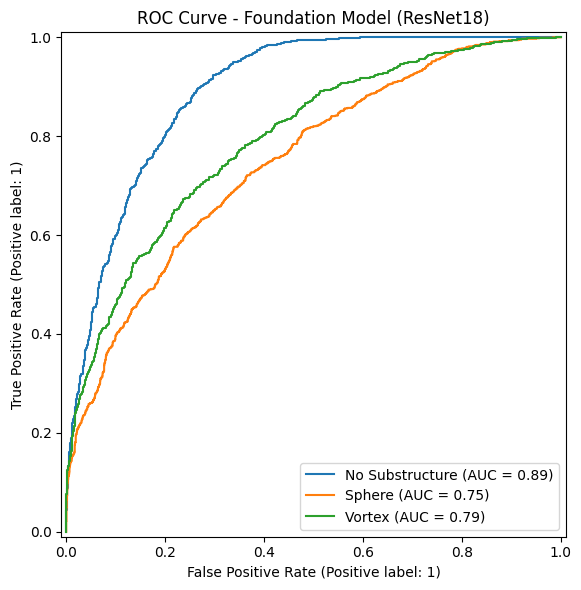

ROC curve saved ✔


In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

model.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.cuda().float()
        probs = F.softmax(model(imgs), dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs  = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
print(f"Macro AUC: {auc:.4f}")

y_bin = label_binarize(all_labels, classes=[0,1,2])
plt.figure(figsize=(7,6))
for i, name in enumerate(["No Substructure", "Sphere", "Vortex"]):
    RocCurveDisplay.from_predictions(y_bin[:,i], all_probs[:,i],
                                      name=name, ax=plt.gca())
plt.title("ROC Curve - Foundation Model (ResNet18)")
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()
print("ROC curve saved ✔")


## Baseline Foundation Model Results

- A supervised ResNet18 model is trained as a baseline without representation pretraining.
- The model achieves substantially higher classification accuracy compared to the autoencoder-based classifier.
- ROC analysis indicates improved class separability, establishing a strong reference point for evaluating representation learning strategies.
- This baseline highlights the benefits of supervised signals but does not explicitly enforce structural representation learning.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights


class MultiTaskFoundationModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        base = resnet18(weights=ResNet18_Weights.DEFAULT)

        old_conv = base.conv1
        new_conv = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        with torch.no_grad():
            new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
        base.conv1 = new_conv


        self.encoder = nn.Sequential(*list(base.children())[:-2])

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        feats = self.encoder(x)

        pooled = self.pool(feats).flatten(1)
        logits = self.classifier(pooled)

        recon = self.decoder(feats)

        return logits, recon


model = MultiTaskFoundationModel().cuda()
print("Multitask model ready")

Multitask model ready


In [ ]:
cls_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
recon_loss_fn = nn.MSELoss()

LAMBDA_RECON = 0.1

In [ ]:
import torch.nn.functional as F
EPOCHS2 = 15

opt2 = torch.optim.Adam([
    {"params": model.encoder.parameters(), "lr": 3e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4},
    {"params": model.decoder.parameters(), "lr": 1e-4},
], weight_decay=1e-4)

scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(opt2, T_max=EPOCHS2)

for epoch in range(EPOCHS2):
    model.train()

    correct = 0
    total = 0

    running_loss = 0
    running_cls = 0
    running_recon = 0

    for imgs, labels in loader:
        imgs = imgs.cuda(non_blocking=True)
        labels = labels.cuda()

        logits, recon = model(imgs)

        loss_cls = cls_loss_fn(logits, labels)
        recon = F.interpolate(recon, size=imgs.shape[-2:], mode="bilinear", align_corners=False)
        loss_recon = recon_loss_fn(recon, imgs)
        loss = loss_cls + LAMBDA_RECON * loss_recon

        opt2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt2.step()

        running_loss += loss.item()
        running_cls += loss_cls.item()
        running_recon += loss_recon.item()

        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    scheduler2.step()

    train_acc = correct / total
    val_acc = evaluate(model, val_loader)

    print(
        f"Epoch {epoch} | "
        f"loss {running_loss/len(loader):.4f} | "
        f"cls {running_cls/len(loader):.4f} | "
        f"recon {running_recon/len(loader):.4f} | "
        f"train {train_acc:.3f} | "
        f"val {val_acc:.3f}"
    )

Epoch 0 | loss 1.1442 | cls 1.1383 | recon 0.0593 | train 0.350 | val 0.353
Epoch 1 | loss 1.1192 | cls 1.1173 | recon 0.0189 | train 0.370 | val 0.395
Epoch 2 | loss 1.0951 | cls 1.0934 | recon 0.0168 | train 0.399 | val 0.432
Epoch 3 | loss 1.0588 | cls 1.0572 | recon 0.0157 | train 0.450 | val 0.476
Epoch 4 | loss 1.0223 | cls 1.0208 | recon 0.0145 | train 0.480 | val 0.489
Epoch 5 | loss 0.9834 | cls 0.9821 | recon 0.0134 | train 0.524 | val 0.533
Epoch 6 | loss 0.9481 | cls 0.9468 | recon 0.0131 | train 0.561 | val 0.597
Epoch 7 | loss 0.9079 | cls 0.9066 | recon 0.0131 | train 0.594 | val 0.631
Epoch 8 | loss 0.8811 | cls 0.8798 | recon 0.0131 | train 0.619 | val 0.641
Epoch 9 | loss 0.8640 | cls 0.8627 | recon 0.0133 | train 0.637 | val 0.657
Epoch 10 | loss 0.8433 | cls 0.8420 | recon 0.0132 | train 0.648 | val 0.668
Epoch 11 | loss 0.8284 | cls 0.8271 | recon 0.0131 | train 0.661 | val 0.677
Epoch 12 | loss 0.8276 | cls 0.8263 | recon 0.0132 | train 0.664 | val 0.682
Epoch 13 

In [ ]:
torch.save(model.state_dict(), "multitask_foundation.pt")

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        logits, _ = model(imgs)
        probs = torch.softmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)
print("Shapes:", all_probs.shape, all_labels.shape)

Shapes: (3000, 3) (3000,)


In [ ]:
from sklearn.preprocessing import label_binarize

num_classes = 3
y_true = label_binarize(all_labels, classes=[0,1,2])

aucs = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    aucs.append(auc(fpr, tpr))

print("Per-class AUC:", aucs)
print("Macro AUC:", np.mean(aucs))

Per-class AUC: [np.float64(0.9149864033383878), np.float64(0.8065560934818228), np.float64(0.8399822012894447)]
Macro AUC: 0.8538415660365518


In [ ]:
baseline_model = FoundationModel(encoder, head).cuda()
baseline_model.load_state_dict(torch.load("foundation_finetuned.pt"))
baseline_model.eval()

FoundationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
base_probs = []
base_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()

        logits = baseline_model(imgs)
        probs = torch.softmax(logits, dim=1)

        base_probs.append(probs.cpu().numpy())
        base_labels.append(labels.cpu().numpy())

base_probs = np.concatenate(base_probs)
base_labels = np.concatenate(base_labels)

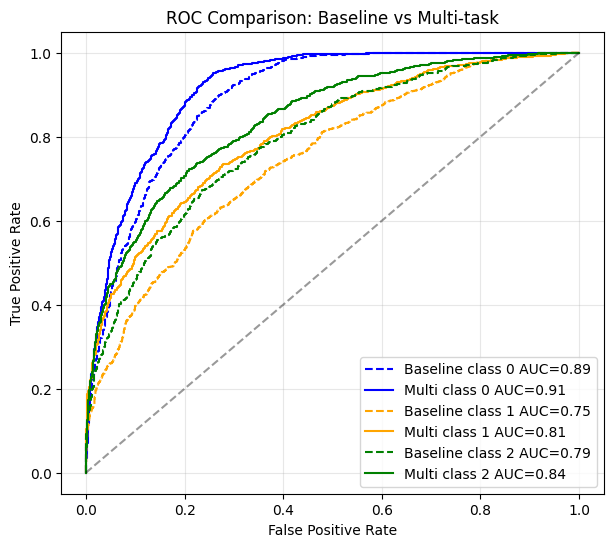

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

num_classes = 3

y_base = label_binarize(base_labels, classes=[0,1,2])
y_multi = label_binarize(all_labels, classes=[0,1,2])

plt.figure(figsize=(7,6))

colors = ["blue","orange","green"]

for i in range(num_classes):

    fpr_b, tpr_b, _ = roc_curve(y_base[:, i], base_probs[:, i])
    auc_b = auc(fpr_b, tpr_b)

    fpr_m, tpr_m, _ = roc_curve(y_multi[:, i], all_probs[:, i])
    auc_m = auc(fpr_m, tpr_m)

    plt.plot(fpr_b, tpr_b, linestyle="--",
             label=f"Baseline class {i} AUC={auc_b:.2f}",
             color=colors[i])

    plt.plot(fpr_m, tpr_m,
             label=f"Multi class {i} AUC={auc_m:.2f}",
             color=colors[i])

plt.plot([0,1],[0,1],"k--",alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: Baseline vs Multi-task")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Multi-task Foundation Model Results

- A multi-task architecture is introduced where the shared encoder simultaneously supports classification and reconstruction.
- Joint optimization encourages the model to preserve structural information while improving discriminative features.
- The multi-task model achieves higher validation accuracy than the supervised baseline and improves macro AUC across all classes.
- ROC curves demonstrate consistent gains in ranking performance, particularly for challenging substructure classes.
- These results indicate stronger learned representations compared to both autoencoder-only and purely supervised approaches.

## Representation Analysis

- Autoencoder training captures global morphology but produces features with limited class separability.
- Supervised baseline training improves discriminative power but does not explicitly preserve structural reconstruction signals.
- Multi-task learning balances reconstruction and classification, leading to richer feature representations.
- Improvements in ROC/AUC indicate that the encoder learns more robust ranking of lens morphologies.
- The shared encoder demonstrates characteristics of a reusable foundation model suitable for downstream transfer tasks.

## Discussion

- Classification performance is influenced by morphological similarity between spherical and vortex substructures, which limits achievable accuracy.
- Reconstruction objectives alone prioritize visual fidelity rather than class-discriminative features, explaining the weak performance of autoencoder-based classification.
- Multi-task learning acts as an implicit regularizer, encouraging the encoder to retain structural cues while improving decision boundaries.
- The lightweight ResNet18 backbone provides efficient experimentation but constrains the upper bound of representation quality.
- These observations suggest that stronger pretraining strategies and larger architectures may further improve foundation model performance.

## Conclusion

- This work presents a foundation-style learning pipeline for gravitational lensing image analysis using convolutional neural networks.
- Experiments show that purely unsupervised autoencoder training captures structural information but does not provide strong discriminative representations.
- A supervised ResNet18 baseline establishes reliable classification performance, serving as a reference for representation improvements.
- The proposed multi-task framework combining reconstruction and classification consistently improves validation accuracy and ROC/AUC, indicating stronger learned representations.
- The shared encoder demonstrates potential as a reusable foundation model for downstream astrophysical tasks, motivating further exploration of transfer learning approaches.

## Future Work

- Extend the multi-task encoder toward unsupervised anomaly detection pipelines, following approaches where autoencoders and generative models identify lensing images containing dark matter substructure without explicit labels. :contentReference[oaicite:0]{index=0}
- Develop regression models to estimate physical properties of substructure such as mass fraction, position, and morphology, enabling the transition from classification to parameter inference.
- Explore domain adaptation strategies to bridge the gap between simulated lensing data and real observational surveys, improving model robustness under distribution shifts. :contentReference[oaicite:1]{index=1}
- Investigate hybrid pipelines combining unsupervised discovery with supervised classification to support theory-agnostic dark matter searches using strong lensing images. :contentReference[oaicite:2]{index=2}
- Evaluate foundation encoders on large upcoming survey data, where deep learning methods are expected to play a central role in identifying dark matter substructure signatures. :contentReference[oaicite:3]{index=3}